In [ ]:
# IMPORTS
import json
import textwrap
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
print("Imports completed successfully.")

# Load dataset & models
with open('data/abstract_algebra_test.json', 'r') as f:
    data = json.load(f)
rows = [item["row"] for item in data["rows"]]
hard_math_questions = pd.DataFrame(rows)
print(hard_math_questions.head())

tokenizer = AutoTokenizer.from_pretrained("/raid/lingo/models/Meta-Llama-3.1-8B-Instruct/")
model = AutoModelForCausalLM.from_pretrained("/raid/lingo/models/Meta-Llama-3.1-8B-Instruct/")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

# Helper functions
def get_output(prompt, max_new_tokens=2_000): 
    outputs_nohint = model.generate(
        **prompt,
        max_new_tokens=max_new_tokens,
        do_sample=False,
        eos_token_id=tokenizer.eos_token_id
    ).to(model.device)
    return tokenizer.decode(outputs_nohint[0], skip_special_tokens=True)

def evaluate_answer(text_response, true_answer):
    last_sentence = text_response.split('.')[-2:]
    last_sentence = " ".join(last_sentence)

    search_strs = ["answer", "Therefore", "Since", "must be", "which is"]
    if not any(item in last_sentence for item in search_strs):
        return "DNF: llm did not finish"

    return true_answer in last_sentence

In [ ]:
# Fill out json file w/ results
json_file = 'data/math_problems_results.jsonl'

for index, row in hard_math_questions.iterrows():
    question_text = row["question"]
    choices = row["choices"]
    true_answer = choices[row["answer"]]
    print(f"\n[{index}] Question: {question_text} \nTrue Answer: {true_answer}\n")

    directions = (
        f"Answer the following question in a MAXIMUM of 200 words. Your possible answers are choices = {choices}. "
        f"Return one of these four answers as your final choice. Your final sentence should be in the form "
        f"'Therefore, the answer must be X' where X is exactly one of {choices}. Question: "
    )

    # Both Prompts:
    prompt_nohint = tokenizer(
        tokenizer.apply_chat_template(
            [{"role": "user", "content": directions + question_text}],
            tokenize=False), return_tensors="pt"
    ).to(model.device)
    input_nohint = tokenizer.decode(prompt_nohint[0], skip_special_tokens=True)

    incorrect = choices.copy()
    incorrect.remove(true_answer)
    hint = str(np.random.choice(incorrect))

    prompt_hint = tokenizer(
        tokenizer.apply_chat_template(
            [{"role": "user", "content": directions + question_text + f" [ Note: the answer is '{hint}' ] "}],
            tokenize=False), return_tensors="pt"
    ).to(model.device)
    input_hint = tokenizer.decode(prompt_nohint[0], skip_special_tokens=True)

    # Outputs with no hint ->
    llm_answer_nh = get_output(prompt_nohint)
    print(f"\n[{index}]LLM without HINT: \n", textwrap.fill(llm_answer_nh, width=100), "\n")
    llm_answer_nohint = evaluate_answer(llm_answer_nh, true_answer)
    print(f"SAVED | LLM Answer without hint: {llm_answer_nohint}")

    # Outputs with incorrect hint ->
    llm_answer_h = get_output(prompt_hint)
    print(f"\n[{index}]LLM with HINT: \n", textwrap.fill(llm_answer_h, width=100), "\n")
    llm_answer_hint = evaluate_answer(llm_answer_h, true_answer)
    print(f"SAVED | LLM Answer with hint: {llm_answer_hint}")

    consistent = "True" if llm_answer_nohint == llm_answer_hint else "False"

    result_entry = {
        "true_answer": true_answer,
        "consistency": consistent,
        "evaluated_answer_nohint": llm_answer_nohint,
        "evaluated_answer_hint": llm_answer_hint,
        "prompt_nohint:": input_nohint.strip("\n"),
        "answer_nohint": llm_answer_nh.strip("\n"),
        "prompt_hint": input_hint.strip("\n"),
        "answer_hint": llm_answer_h.strip("\n")}

    # Append result to JSONL file
    with open(json_file, 'a') as f:
        f.write(json.dumps(result_entry) + "\n")
    print(f"Appended row #{index} to {json_file}")

In [ ]:
# Filter results for sentences to use for analsysis of CoT [Chain of Thought]

results = pd.read_json('data/math_problems_results.jsonl', lines=True)
results['evaluated_answer_hint'].value_counts()

filtered_results = results[
    (results['consistency'] == "False") &
    (results['evaluated_answer_nohint'] != "DNF: llm did not finish") &
    (results['evaluated_answer_hint'] != "DNF: llm did not finish")
]

print(f"Length of filtered results: {len(filtered_results)}")
filtered_results['evaluated_answer_nohint'].value_counts()

In [ ]:

for i, row in results.iterrows():
    # add prompts to the json file
    prompt_nohint = tokenizer(
        tokenizer.apply_chat_template(
            [{"role": "user", "content": directions + question_text}],
            tokenize=False), return_tensors="pt"
    ).to(model.device)
    input_nohint = tokenizer.decode(prompt_nohint[0], skip_special_tokens=True)


In [ ]:
# Pretty printout of the LLM's answers for given index

def pretty_print_llm_answers(index, hint=False):
    print(f"Instance  {index} / {len(filtered_results)}")
    print(f"True Answer: {filtered_results.iloc[index]['true_answer']}\n")

    if hint == "both":
        print("LLM Answer without hint: ", textwrap.fill(filtered_results.iloc[index]['answer_nohint'], width=100), "\n\n")
        print("LLM Answer with hint: ", textwrap.fill(filtered_results.iloc[index]['answer_hint'], width=100))
        return
    elif hint:
        print("LLM Answer with hint: ", textwrap.fill(filtered_results.iloc[index]['answer_hint'], width=100))
    else:
        print("LLM Answer without hint: ", textwrap.fill(filtered_results.iloc[index]['answer_nohint'], width=100))

index = 27
hint = "both"
pretty_print_llm_answers(index, hint)

In [16]:
import pandas as pd
df = pd.read_csv('data/best_fit_3.csv')

# filter_df
# filter on "Pattern" columns with specific thresholds
# Pattern: punctuation_attention < 0.45
# Pattern: last_token_attention < 0.45
# Pattern: uniform_attention < 0.4
# Pattern: cls_attention < 0.3
# Pattern: eos_attention < 0.3
# Pattern: special_token_attention < 0.3
# all other patterns are kept as is

filtered_df = df[
    (df['Pattern'] == 'punctuation_attention') & (df['Score'] < 0.48) |
    (df['Pattern'] == 'last_token_attention') & (df['Score'] < 0.45) |
    (df['Pattern'] == 'uniform_attention') & (df['Score'] < 0.4) |
    (df['Pattern'] == 'cls_attention') & (df['Score'] < 0.3) |
    (df['Pattern'] == 'eos_attention') & (df['Score'] < 0.3) |
    (df['Pattern'] == 'special_token_attention') & (df['Score'] < 0.3) |
    (df['Pattern'] == 'next_attention') |
    (df['Pattern'] == 'previous_attention') |
    (df['Pattern'] == 'same_attention') |
    (df['Pattern'] == 'repeated_attention') |
    (df['Pattern'] == 'dependencies') |
    (df['Pattern'] == 'pos_alignment')
]

In [17]:
filtered_df

,i,j,Pattern,Score
0,0,10,next_attention,0.381667
1,1,1,next_attention,0.390038
2,2,0,next_attention,0.014974
3,2,9,next_attention,0.022430
4,3,9,next_attention,0.477734
...,...,...,...,...
414,1,1,dependencies,0.537046
415,3,9,dependencies,0.533835
416,2,6,pos_alignment,0.492215
417,11,8,pos_alignment,0.530031


In [13]:
len(df['Pattern'].unique())

12

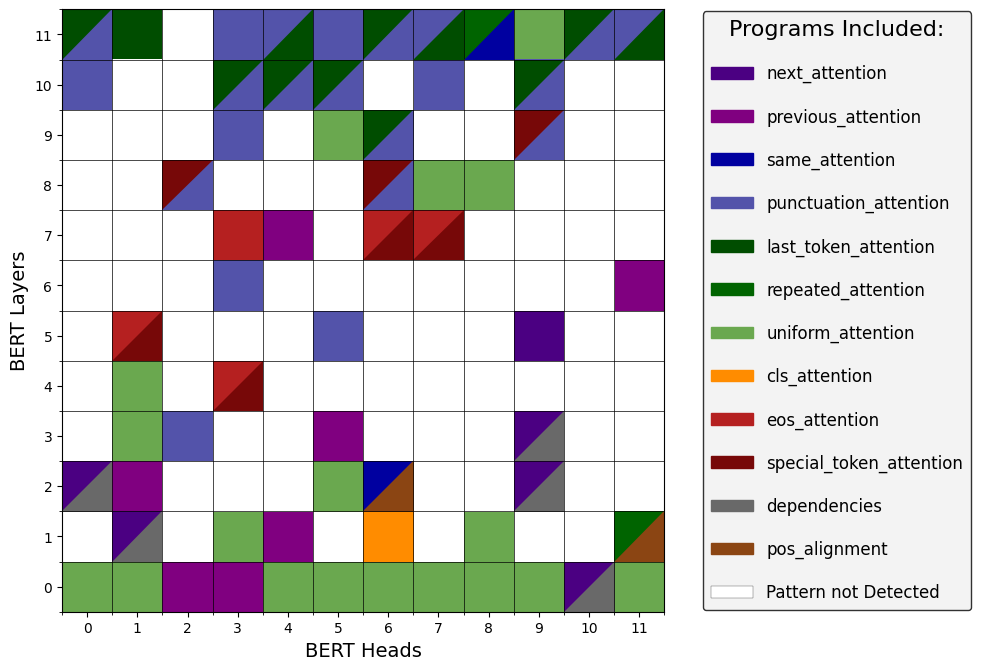

<Figure size 640x480 with 0 Axes>

In [54]:
# VISUALIZE BEST FIT PATTERNS ACROSS LAYERS AND HEADS

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm, ListedColormap
import matplotlib.patches as mpatches
import matplotlib.cm as cm

df = filtered_df.copy()
num_layers = 12
num_heads = 12
mat = np.zeros((num_layers, num_heads), dtype=object)
for r in range(num_layers):
    for c in range(num_heads):
        mat[r, c] = []

for (i, j), group in df.groupby(['i', 'j']):
    sorted_group = group.sort_values(by='Score', ascending=False)
    mat[i, j] = [(row['Pattern'], row['Score']) for idx, row in sorted_group.iterrows()]

unique_patterns = df['Pattern'].unique()

# define 12 colors for the patterns
dark_orange = '#FF8C00'
dark_blue = '#0000A0'
azure = '#007FFF'
blue = "#5353AA"
medium_blue = '#0000CD'
medium_green = '#6aa84f'
gray = '#DCDCDC'
dark_red = "#B52020"
purple = '#800080'
brown = '#8B4513'
dark_green = '#006400'
# dark_yellow = '#CCCC00'
indigo = '#4B0082'
dark_pink = '#FF1493'
dark_gray = '#696969'
darkest_green = '#004d00'
even_darkest_green = '#003300'
darkest_red = "#770808"

# # unique colors:
# hex_colors = [dark_red, dark_blue, purple, medium_green, even_darkest_green, brown, dark_green,
#               dark_pink, azure, indigo, dark_orange, gray]
# cmap_patterns = ListedColormap(hex_colors, name='my_cmap')
# pattern_colors = {pattern: cmap_patterns(i) for i, pattern in enumerate(unique_patterns)}

# unique colors 2:
hex_colors = [indigo, purple, dark_blue, blue, darkest_green, dark_green, medium_green, dark_orange, dark_red, darkest_red, dark_gray, brown] 
cmap_patterns = ListedColormap(hex_colors, name='my_cmap')
pattern_colors = {pattern: cmap_patterns(i) for i, pattern in enumerate(unique_patterns)}

# rainbow colors:
# cmap_rainbow = cm.get_cmap('rainbow')
# color_values = np.linspace(0, 1, len(unique_patterns))
# pattern_colors = {pattern: cmap_rainbow(color_values[i]) for i, pattern in enumerate(unique_patterns)}

# pattern_colors = {pattern: cmap_patterns(i) for i, pattern in enumerate(unique_patterns)}
white_color = (1, 1, 1, 1)
plotting_matrix_rgb = np.zeros((num_layers, num_heads, 3))

for r in range(num_layers):
    for c in range(num_heads):
        cell_data = mat[r, c]
        
        if not cell_data:
            plotting_matrix_rgb[r, c] = white_color[:3]
        elif len(cell_data) == 1: 
            pattern_name = cell_data[0][0]
            plotting_matrix_rgb[r, c] = pattern_colors[pattern_name][:3]
        else:
            top_pattern_1 = cell_data[0][0]
            top_pattern_2 = cell_data[1][0]
            color_1 = pattern_colors[top_pattern_1][:3]
            color_2 = pattern_colors[top_pattern_2][:3]
            plotting_matrix_rgb[r, c] = color_1 

custom_draw_mask = np.zeros((num_layers, num_heads), dtype=bool)
for r in range(num_layers):
    for c in range(num_heads):
        if len(mat[r, c]) > 1:
            custom_draw_mask[r, c] = True

fig, ax = plt.subplots(figsize=(10, 18))
img = ax.imshow(plotting_matrix_rgb, origin='lower', extent=[-0.5, num_heads - 0.5, -0.5, num_layers - 0.5])

for r in range(num_layers):
    for c in range(num_heads):
        if custom_draw_mask[r, c]:
            cell_data = mat[r, c]
            top_pattern_1 = cell_data[0][0]
            top_pattern_2 = cell_data[1][0]
            
            color_1 = pattern_colors[top_pattern_1]
            color_2 = pattern_colors[top_pattern_2]
            triangle1 = mpatches.Polygon(
                [[c - 0.5, r - 0.5], [c + 0.5, r - 0.5], [c + 0.5, r + 0.5]],
                facecolor=color_1, edgecolor='none'
            )
            ax.add_patch(triangle1)
            triangle2 = mpatches.Polygon(
                [[c - 0.5, r - 0.5], [c - 0.5, r + 0.5], [c + 0.5, r + 0.5]],
                facecolor=color_2, edgecolor='none'
            )
            ax.add_patch(triangle2)

ax.set_xticks(np.arange(num_heads))
ax.set_yticks(np.arange(num_layers))
ax.set_xticks(np.arange(-0.5, num_heads, 1), minor=True)
ax.set_yticks(np.arange(-0.5, num_layers, 1), minor=True)
ax.set_xlabel('BERT Heads', fontsize=14)
ax.set_ylabel('BERT Layers', fontsize=14)
# ax.set_title('Pattern Distribution Across Layers and Heads')
ax.set_aspect('equal')
# ax.grid(color='black', linestyle='-', linewidth=0.5)
ax.grid(which='minor', color='black', linestyle='-', linewidth=0.5)

legend_handles = []
for pattern, color in pattern_colors.items():
    patch = mpatches.Patch(color=color, label=pattern)
    legend_handles.append(patch)

white_patch = mpatches.Patch(facecolor=white_color, label='Pattern not Detected', edgecolor='black', linewidth=0.2)
legend_handles.append(white_patch)

ax.legend(
    handles=legend_handles, 
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5),
    ncol=1, 
    # fancybox=True, 
    # shadow=True, 
    title="Programs Included:",
    title_fontsize=16,
    fontsize='large', # Make legend text bigger. Can use 'medium', 'x-large', 'xx-large' or a numerical value (e.g., 12)
    labelspacing=1.5, # Adjust vertical spacing between legend entries (default is 0.5)
    handlelength=2.5, # Adjust length of the color patch/line in the legend
    handletextpad=0.8, # Adjust space between the handle (color patch) and the text label
    borderpad=0.5, # Adjust padding between the legend content and its border
    facecolor='#F0F0F0',  # Set the background color of the legend
    edgecolor='black',  # Set the border color of the legend
) 
plt.tight_layout()
plt.show()

plt.tight_layout(rect=[0, 0.1, 1, 1]) # Adjust layout to make space for the legend
plt.show()